# Compare peptigate outputs against RibORF peptide predictions

This notebook compares peptigate peptide predictions against those with ribosomal profiling support.
Ribosome profiling data is generated by sequencing fragments of mRNA that are protected by ribosomes, offering a snapshot of translation in action at a given moment.
This technique precisely determines which regions of mRNA are being actively translated into proteins, providing insights into gene expression and the regulation of protein synthesis.
A recent paper, ["Widespread stable noncanonical peptides identified by integrated analyses of ribosome profiling and ORF features](https://doi.org/10.1038/s41467-024-46240-9) developed a tool called RibORF to carefully predict open reading frames (ORFs) from ribosome profiling data.
The paper used their RibORF tool on hundreds of human ribosomal profiling data sets and predicted ORFs from that data.

RibORF detects specific kinds of ORFs, which we detail in the table below.
The two types of ORFs that peptigate can detect are bolded.
Peptigate might also be able to detect uORF/iORF/dORF/ouORF/odORFs when the input transcripts that are screened are fragmented.

| Type        | Explanation |
|-------------|-------------|
| uORF        | Upstream ORF in the 5' UTR, can regulate the main ORF's translation. |
| **noncoding**   | ORFs not translated into functional proteins, may have regulatory roles. |
| iORF        | Internal ORFs within another ORF's coding sequence, in a different frame. |
| dORF        | Downstream ORF in the 3' UTR, can influence mRNA stability or translation. |
| ouORF       | Overlapping upstream ORF with the main ORF's start, affects main ORF translation. |
| **canonical**   | The primary ORF expected to produce the functional protein. |
| truncation  | ORFs that result in a shorter protein, due to premature start or stop codons. |
| odORF       | Overlapping downstream ORF with the main ORF, potentially affects protein stability. |
| extension   | ORFs extending beyond the canonical stop codon, leading to longer protein products. |
| readthrough | Ribosome ignores the stop codon, extending translation into the 3' UTR. |
| seqerror    | Likely represents ORFs identified due to sequencing errors, not genuine translational events. |


Below, we compare peptigate predictions against RibORF predictions.

## Set up notebook

In [1]:
library(tidyverse)
library(ggExtra)
library(arcadiathemeR)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Compare number and types of predictions

RibORF predicted 57,499 ORFs (filtered to those with a length of 100 or less when translated into amino acids) while peptigate predicted 4,413 sequences.

However, this comparison is not apples: apples.
As noted in the intro to this notebook, RibORF predicts ORFs in coding transcripts that peptigate would ignore.
In this context, the much higher prediction by RibORF as compared to peptigate makes sense.

Further, deeppeptide and nlpprecursor predict cleavage peptides and it isn't clear to me the extent to which we would expect cleavage peptides to be supported by ribosomal profiling data.

In [2]:
peptigate <- read_tsv("../../peptigate/results/predictions/peptide_predictions.tsv.gz", show_col_types = FALSE) %>%
  rename_with(~paste0("peptigate_", .))

In [3]:
peptigate_distinct <- peptigate %>%
 select(peptigate_prediction_tool, peptigate_protein_sequence) %>%
 distinct()

nrow(peptigate_distinct)

peptigate_summary <- peptigate_distinct %>% 
  group_by(peptigate_prediction_tool) %>% 
  tally()
peptigate_summary

[1] 4235

peptigate_prediction_tool,n
<chr>,<int>
deeppeptide,1549
nlpprecursor,431
plmutils,2255


In [4]:
riborf <- read_tsv("riborf_human.bed", show_col_types = FALSE,
                   col_names = c("chromosome", "start", "end", "name", 
                                 "score", "strand", "thickStart", "thickEnd",
                                 "itemRgb", "blockCount", "blockSizes", "blockStarts", 
                                 "transcriptInfo")) %>%
  separate(name, into = c("transcript_name", "num_exons", "loc_info", "type", "start_codon"), sep = "\\|", remove = FALSE) %>%
  separate(loc_info, into = c("length", "relative_start", "relative_end"), sep = ":") %>%
  mutate(translated_length = (as.numeric(relative_end) - as.numeric(relative_start)) / 3) %>%
  rename_with(~paste0("riborf_", .))

riborf_100 <- riborf %>%
  filter(riborf_translated_length < 101)

# how many riborf prediction of length < 100 were there?
nrow(riborf_100)

[1] 57499

In [5]:
# what types of ORFs did RibORF detect?
riborf_100 %>% group_by(riborf_type) %>% tally() %>% arrange(desc(n))

riborf_type,n
<chr>,<int>
uORF,28386
noncoding,11251
iORF,5874
dORF,4665
ouORF,4135
canonical,1367
truncation,1205
odORF,571
extension,34


## Do peptigate and RibORF detect some of the same peptide sequences?

To test whether peptigate and RibORF detect some of the same sequences, we BLASTp'd the peptigate peptide predictions against a database of RibORF predictions.
While the majority of peptigate predicted peptides have a hit against the RibORF data, only cleavage peptides (deeppeptide, nlpprecursor) have mostly strong hits (>90% percent identity, >90% query coverage) while sORF peptides (plmutils) do not.

In [6]:
blastp <- read_tsv("peptigate_sequences_vs_riborf_blastp.tsv",
                   col_names = c("qseqid", "qlen", "qseq", "sseqid", "slen", 
                                 "sseq", "pident", "length", "mismatch",
                                 "gapopen", "qstart", "qend", "qcov",
                                 "sstart", "send", "evalue", "bitscore"),
                  show_col_types = F)

In [7]:
blastp <- read_tsv("peptigate_sequences_vs_riborf_blastp.tsv",
                   col_names = c("qseqid", "qlen", "qseq", "sseqid", "slen", 
                                 "sseq", "pident", "length", "mismatch",
                                 "gapopen", "qstart", "qend",
                                 "sstart", "send", "qcovhsp", "evalue", "bitscore"),
                  show_col_types = F) %>%
  group_by(qseqid) %>%
  slice_max(bitscore) %>%
  slice_min(evalue) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  distinct()

In [8]:
blastp <- blastp %>%
  # join with peptigate results to get prediction tool
  left_join(peptigate, by = c("qseqid" = "peptigate_peptide_id")) %>%
  # remove unwanted columns from peptigate join 
  select(-peptigate_start, -peptigate_end, -peptigate_peptide_class, 
         -peptigate_nlpprecursor_class_score, -peptigate_nlpprecursor_cleavage_score,
         -peptigate_nucleotide_sequence) %>%
  # join with riborf results to get riborf ORF type
  left_join(riborf, by = c("sseqid" = "riborf_name")) %>%
  # remove unwanted columns from riborf join, only keep riborf_type, riborf_start_codon,
  select(-riborf_chromosome, -riborf_start, -riborf_end,
         -riborf_transcript_name, -riborf_num_exons, -riborf_length, 
         -riborf_relative_start, -riborf_relative_end, 
         -riborf_start_codon, -riborf_score, -riborf_strand, -riborf_thickStart, 
         -riborf_thickEnd, -riborf_itemRgb, -riborf_blockCount, -riborf_blockSizes, 
         -riborf_blockStarts, -riborf_translated_length)

In [9]:
# filter to distinct sequences (not guaranteed distinct after join)
blastp_distinct <- blastp %>%
  select(-qseqid, -sseqid) %>%
  distinct()

# filter to sORF sequences
blastp_distinct_sorf <- blastp_distinct %>%
  filter(peptigate_prediction_tool == "plmutils")

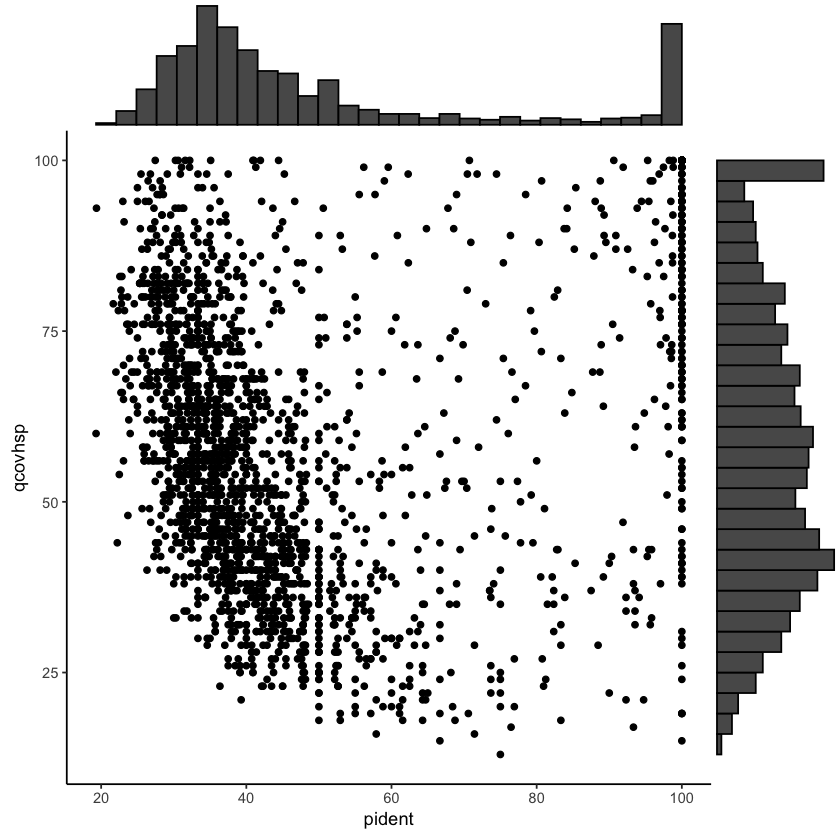

In [10]:
plt1 <- ggplot(blastp_distinct_sorf, aes(x = pident, y = qcovhsp)) +
  geom_point() +
  theme_classic() +
  theme(legend.position = "bottom")

ggMarginal(plt1, type = "histogram")

## What types of predictions are validated by the RibORF data?

Peptides predicted by DeepPeptide and NLPPrecursor continue to have the most support in orthogonal data.
However, RibORF data only shows that the canonical parent proteins (precursor proteins) are translated, not that they are subsequently cleaved.
In contrast, RibORF data does provide direct support for sORFs that encode proteins.
One limitation is that the sORF would need to be both transcribed and translated under the conditions in which the RibORF data is created.
In contrast, the RibORF data analyzed here includes hundreds of data sets under different conditions, it is not exhaustive.
For example, we do not anticipate that neonatal RibORF data are included in this study.

Approximately 13% of plmutils predictions have support in RibORF data.
Of this, 8.4% come from canonical ORFs while 2.7% come from non-coding regions.
This matches previous observations that sORFs are becoming increasingly recognized as coding elements in the genome and that many transcripts previously thought to be non-coding encode sORFs.
While other predictions only account for approximately 2% of observations, this also matches with previous findings that while the majority of sORFs that are encoded upstream, downstream, or overlapping with longer transcripts regulate those transcripts, some may have independent bioactive roles.

Even though it is exciting to see that a fraction of sORF predictions are validated by RibORF or peptipedia data, only 18% of predictions have orthogonal evidence of support.
Given this, we are interested in new ways of validating our peptide prediction pipeline, particularly for sORF predictions.
We are also curious if this matches with the current state of the literature.

In [11]:
riborf_vs_peptigate_summary <- blastp_distinct %>% 
  filter(pident > 90) %>%
  group_by(peptigate_prediction_tool, riborf_type) %>%
  summarize(num = n(), 
            mean_pident = mean(pident),
            mean_length = mean(length),
            mean_qcovhsp = mean(qcovhsp)) %>%
  arrange(desc(num))

riborf_vs_peptigate_summary

`summarise()` has grouped output by 'peptigate_prediction_tool'. You can override using the `.groups` argument.


peptigate_prediction_tool,riborf_type,num,mean_pident,mean_length,mean_qcovhsp
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
deeppeptide,canonical,928,99.83594,22.17888,97.89224
plmutils,canonical,189,98.90130,67.06349,81.59259
nlpprecursor,canonical,102,99.61832,41.07843,93.47059
plmutils,noncoding,61,99.01000,52.78689,73.18033
deeppeptide,extension,42,100.00000,23.69048,99.23810
deeppeptide,truncation,31,100.00000,22.90323,96.96774
nlpprecursor,uORF,27,99.91181,46.40741,77.88889
nlpprecursor,truncation,12,98.16600,33.75000,86.08333
plmutils,uORF,11,99.14609,51.18182,76.00000


In [12]:
blastp_distinct %>% 
  filter(pident > 90) %>%
  group_by(peptigate_prediction_tool) %>%
  summarize(num = n(), 
            mean_pident = mean(pident),
            mean_length = mean(length),
            mean_qcovhsp = mean(qcovhsp)) %>%
  arrange(desc(num))

peptigate_prediction_tool,num,mean_pident,mean_length,mean_qcovhsp
<chr>,<int>,<dbl>,<dbl>,<dbl>
deeppeptide,1015,99.85000,22.22365,97.86305
plmutils,288,98.94451,62.89236,78.96875
nlpprecursor,167,99.54653,41.28743,87.90419


### Pull out numbers to calculate percent of sORF hits against different types of ribORF ORFs

In [13]:
total_number_of_sorf_peptigate_predictions <- peptigate_summary %>%
  filter(peptigate_prediction_tool == "plmutils") %>%
  pull(n)

total_number_of_sorf_peptigate_predictions

[1] 2255

In [14]:
# canonical
total_number_of_sorf_hits_canonical_riborf <- riborf_vs_peptigate_summary %>%
  filter(peptigate_prediction_tool == "plmutils") %>%
  filter(riborf_type == "canonical") %>%
  pull(num)

total_number_of_sorf_hits_canonical_riborf

total_number_of_sorf_hits_canonical_riborf/total_number_of_sorf_peptigate_predictions

[1] 189

[1] 0.08381375

In [15]:
# noncoding
total_number_of_sorf_hits_noncoding_riborf <- riborf_vs_peptigate_summary %>%
  filter(peptigate_prediction_tool == "plmutils") %>%
  filter(riborf_type == "noncoding") %>%
  pull(num)

total_number_of_sorf_hits_noncoding_riborf

total_number_of_sorf_hits_noncoding_riborf/total_number_of_sorf_peptigate_predictions

[1] 61

[1] 0.027051

In [16]:
# all plmutils ribORF hits

total_number_of_sorf_hits_riborf <- riborf_vs_peptigate_summary %>%
  filter(peptigate_prediction_tool == "plmutils") %>%
  group_by(peptigate_prediction_tool) %>%
  summarize(sum_num = sum(num)) %>%
  pull(sum_num)

total_number_of_sorf_hits_riborf

total_number_of_sorf_hits_riborf/total_number_of_sorf_peptigate_predictions

[1] 288

[1] 0.1277162

## Count how many peptigate-predicted peptides had strong evidence in any orthogonal database

A relatively low amount of sORF-encoded peptide sequences (12.8%) have support in ribORF data.
We had expected this percent to be much higher.
Given this, we were curious how many peptides had evidence in any orthogonal dataset/database.
We looked at how many sORF-encoded peptide predictions had support from the following data types:
1. RibORF (this notebook)
2. Peptipedia (reported by peptigate pipeline)
3. NCBI RefSeq transcriptome curated annotation indicating that the transcript is coding (transcript starts with prefix `NM_*`).

Below, we calculate these numbers.
Our goal was to see if there was more support for sORF-encoded peptides in data sets other than the ribORF data.

### Peptipedia or ribORF evidence

In [17]:
peptigate_annotations_distinct <- read_tsv("../../peptigate/results/predictions/peptide_annotations.tsv.gz", show_col_types = F) %>%
  mutate(peptigate_peptipedia_blast_result = ifelse(!is.na(peptipedia_blast_bitscore), "blast hit", "no blast hit")) %>%
  select(peptigate_peptide_id = peptide_id, peptigate_peptipedia_blast_result) %>%
  left_join(peptigate, by = "peptigate_peptide_id") %>%
  group_by(peptigate_protein_sequence) %>%
  slice_head(n = 1) %>%
  ungroup()

In [18]:
blastp2 <- read_tsv("peptigate_sequences_vs_riborf_blastp.tsv",
                   col_names = c("qseqid", "qlen", "qseq", "sseqid", "slen", 
                                 "sseq", "pident", "length", "mismatch",
                                 "gapopen", "qstart", "qend", "sstart", "send",
                                 "qcovhsp", "evalue", "bitscore"),
                  show_col_types = F) %>%
  group_by(qseqid) %>%
  slice_max(bitscore) %>%
  slice_min(evalue) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  distinct() %>%
  # join with peptigate results to get prediction tool
  right_join(peptigate_annotations_distinct, by = c("qseqid" = "peptigate_peptide_id")) %>%
  # remove unwanted columns from peptigate join 
  select(-peptigate_start, -peptigate_end, -peptigate_peptide_class, 
         -peptigate_nlpprecursor_class_score, -peptigate_nlpprecursor_cleavage_score,
         -peptigate_nucleotide_sequence) %>%
  # join with riborf results to get riborf ORF type
  left_join(riborf, by = c("sseqid" = "riborf_name")) %>%
  # remove unwanted columns from riborf join, only keep riborf_type, riborf_start_codon,
  select(-riborf_chromosome, -riborf_start, -riborf_end,
         -riborf_transcript_name, -riborf_num_exons, -riborf_length, 
         -riborf_relative_start, -riborf_relative_end, 
         -riborf_start_codon, -riborf_score, -riborf_strand, -riborf_thickStart, 
         -riborf_thickEnd, -riborf_itemRgb, -riborf_blockCount, -riborf_blockSizes, 
         -riborf_blockStarts, -riborf_translated_length) %>%
  mutate(riborf_blast_result = ifelse(!is.na(riborf_type), "blast hit", "no blast hit"),
         riborf_blast_result_strong = ifelse(pident >= 90, "blast hit", "no blast hit"))

In [19]:
blastp2 %>%
  mutate(evidence_peptide_is_real = ifelse(peptigate_peptipedia_blast_result == "blast hit" | riborf_blast_result_strong == "blast hit",
                                           "evidence",
                                           "no evidence"),
        evidence_peptide_is_real = ifelse(is.na(evidence_peptide_is_real), "no evidence", evidence_peptide_is_real)) %>%
  group_by(peptigate_prediction_tool, evidence_peptide_is_real) %>%
  tally()

peptigate_prediction_tool,evidence_peptide_is_real,n
<chr>,<chr>,<int>
deeppeptide,evidence,1094
deeppeptide,no evidence,455
nlpprecursor,evidence,176
nlpprecursor,no evidence,255
plmutils,evidence,403
plmutils,no evidence,1852


### Peptipedia, ribORF, or curated coding transcripts in NCBI RefSeq

In [20]:
total_num_peptigate_predictions_with_orthogonal_evidence <- blastp2 %>%
  mutate(evidence_peptide_is_real = ifelse(peptigate_peptipedia_blast_result == "blast hit" | riborf_blast_result_strong  == "blast hit",
                                           "evidence",
                                           "no evidence"),
        evidence_peptide_is_real = ifelse(is.na(evidence_peptide_is_real), "no evidence", evidence_peptide_is_real)) %>%
  # add in already coding by refseq
  mutate(evidence_peptide_is_real = ifelse(peptigate_prediction_tool == "plmutils" & grepl(pattern = "^NM", x = qseqid),
                                           "evidence",
                                           evidence_peptide_is_real)) %>% 
  group_by(peptigate_prediction_tool, evidence_peptide_is_real) %>%
  tally()

total_num_peptigate_predictions_with_orthogonal_evidence

peptigate_prediction_tool,evidence_peptide_is_real,n
<chr>,<chr>,<int>
deeppeptide,evidence,1094
deeppeptide,no evidence,455
nlpprecursor,evidence,176
nlpprecursor,no evidence,255
plmutils,evidence,486
plmutils,no evidence,1769


In [21]:
total_num_sorf_prediction_with_orthogonal_evidence <- total_num_peptigate_predictions_with_orthogonal_evidence %>%
  filter(peptigate_prediction_tool == "plmutils") %>%
  filter(evidence_peptide_is_real == "evidence") %>%
  pull(n)

total_num_sorf_prediction_with_orthogonal_evidence / total_number_of_sorf_peptigate_predictions # riborf or peptipedia hits

[1] 0.2155211

## Conclusion

As with other tests, we find that predictions for cleavage peptides (made by tools DeepPeptide and NLPPrecursor) continue to be better supported by orthogonal data than those made for sORFs (by plmutils).
However, some plmutls peptides do have support, meaning some predictions are likely real.

In [22]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/pepeval/lib/libopenblasp-r0.3.26.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] arcadiathemeR_0.1.0 ggExtra_0.10.0      lubridate_1.9.3    
 [4] forcats_1.0.0       stringr_1.5.1       dplyr_1.1.4        
 [7] purrr_1.0.2         readr_2.1.5         tidyr_1.3.1        
[10] tibble_3.2.1        ggplot2_3.5.0       tidyverse_2.0.0    

loaded via a namespace (and not attached):
 [1] utf8_1.2.4       generics_0.1.3   stringi_1.8.3    hms_1.1.3       
 [5] digest_0.6.35    magrittr_2.0.3   evaluate_0.23    grid_4.3.3      
 [9] timechange_0.3.0 pbdZMQ_0.3-11    fastmap